In [2]:
import numpy as np
import pandas as pd
import requests 
import folium 
import os 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

Solving environment: / 
  - anaconda/osx-64::ca-certificates-2020.1.1-0, anaconda/osx-64::openssl-1.1.1d-h1de35cc_4
  - anaconda/osx-64::openssl-1.1.1d-h1de35cc_4, defaults/osx-64::ca-certificates-2020.1.1-0
  - anaconda/osx-64::ca-certificates-2020.1.1-0, defaults/osx-64::openssl-1.1.1d-h1de35cc_4
  - defaults/osx-64::ca-certificates-2020.1.1-0, defaults/osx-64::openssl-1.1.1d-h1de35ccdone

## Package Plan ##

  environment location: /Users/destipan/opt/anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographicl

## This is unordered version of notebook, more details please to read full report 

In [23]:
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from IPython.display import display_html

### set up FourSquare 

In [4]:
CLIENT_ID = 'YEJU1W3IL5E2YMTN3OHJVKVEBNJ4XC5SR0TL1RFAEYAEBKMX' 
CLIENT_SECRET = 'EATU1VBPHO2XBT0ITFXZHNKXSJEM5P5N25X1F0RVGFVPFBMM' 
VERSION = '20180604'
LIMIT = 30

In [6]:
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [8]:
def get_venues(lat,lng):
    radius=400
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### Generate New York City neighborhood information 

In [9]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [142]:
df = ny_data[ny_data.Borough == 'Manhattan']
df.head()

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude
6,4,Manhattan,Marble Hill,40.876551,-73.910660
100,0,Manhattan,Chinatown,40.715618,-73.994279
101,4,Manhattan,Washington Heights,40.851903,-73.936900
102,4,Manhattan,Inwood,40.867684,-73.921210
103,4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [64]:
map1 = folium.Map(location = [40.758896, -73.985130], zoom_start = 13)
for lat, lng, borough, neighborhood in zip (df['Latitude'], df['Longitude'], df['Borough'],df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker([lat, lng], radius = 5, popup = label, color = 'red', fill=True, fill_opacity = 0.7, parse_html=False).add_to(map1)
map1

### Cluster New York Neighorhoods 

In [103]:
from sklearn.cluster import KMeans
k = 5
t_cluster = ny_data.drop([ 'Borough', 'Neighborhood'], 1)
kmeans = KMeans(n_clusters = k, random_state = 0).fit(t_cluster)
kmeans.labels_
ny_data.insert(0, 'Cluster Labels', kmeans.labels_)

In [106]:
latitude = 40.758896
longitude = -73.985130

kclusters=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_data['Latitude'], ny_data['Longitude'], ny_data['Neighborhood'], ny_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
  # add markers for rental places to map
 
    
       
map_clusters

### Extracted metro station information from wikipedia

In [24]:
URL1 = requests.get('https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_Manhattan').text
bs = BeautifulSoup(URL1, 'lxml')
table = str(bs.table)
display_html(table,raw = True)

Division,Line,Services,Stations in Manhattan,Opened,Continues to
B (IND),02Second Avenue Line,N Q​​,3,"January 1, 2017",N/A
B (IND),06Sixth Avenue Line,B D F M​​​,"13 (6 express-local stations, 5 part of station complexes, 1 shared with Eighth Avenue Line, 1 shared with Queens Boulevard Line)","January 1, 1936",Brooklyn
B (IND),08Eighth Avenue Line,A B C D E​​​​,"30 (9 express-local stations,[^ 2] 7 part of station complexes, 1 shared with Concourse Line, 1 shared with Queens Boulevard Line, 1 shared with Sixth Avenue Line)","September 10, 1932",Brooklyn
A (IRT),42nd Street Line,S,02 (both part of station complexes),"October 27, 1904",N/A
B (BMT),63rd Street Line,N Q​​,01 (shared with IND 63rd Street Line),"October 29, 1989[^ 5]",N/A
B (IND),63rd Street Line,F​,02 (1 shared with BMT 63rd Street Line),"October 29, 1989",Queens
B (BMT),Broadway Line,N Q R​​​,"17 (4 express-local stations,[^ 2] 8 part of station complexes)","September 4, 1917","Brooklyn, Queens"
A (IRT),Broadway–Seventh Avenue Line,1 2 3​​,"38 (6 express-local stations, 7 part of station complexes)","October 27, 1904","the Bronx, Brooklyn"
B (BMT),Canarsie Line(14th Street Crosstown),L,05 (3 part of station complexes),"June 30, 1924",Brooklyn
B (IND),Concourse Line,B D​,"02 (1 express-local station, 1 shared with Eighth Avenue Line)","July 1, 1933",the Bronx


In [80]:
df1 = pd.read_html(table, flavor = 'bs4')
infer_types=False
df11 = df1[0]
df11.head()


,Division,Line,Services,Stations in Manhattan,Opened,Continues to
0,B (IND),Second Avenue Line,​​,3,"January 1, 2017",NaN
1,B (IND),Sixth Avenue Line,​​​,"13 (6 express-local stations, 5 part of statio...","January 1, 1936",Brooklyn
2,B (IND),Eighth Avenue Line,​​​​,"30 (9 express-local stations,[^ 2] 7 part of s...","September 10, 1932",Brooklyn
3,A (IRT),42nd Street Line,NaN,2 (both part of station complexes),"October 27, 1904",NaN
4,B (BMT),63rd Street Line,​​,1 (shared with IND 63rd Street Line),"October 29, 1989[^ 5]",NaN


In [81]:
df12 = df11.drop(['Services', 'Division', 'Opened'], axis = 1)
df12

,Line,Stations in Manhattan,Continues to
0,Second Avenue Line,3,NaN
1,Sixth Avenue Line,"13 (6 express-local stations, 5 part of statio...",Brooklyn
2,Eighth Avenue Line,"30 (9 express-local stations,[^ 2] 7 part of s...",Brooklyn
3,42nd Street Line,2 (both part of station complexes),NaN
4,63rd Street Line,1 (shared with IND 63rd Street Line),NaN
5,63rd Street Line,2 (1 shared with BMT 63rd Street Line),Queens
6,Broadway Line,"17 (4 express-local stations,[^ 2] 8 part of s...","Brooklyn, Queens"
7,Broadway–Seventh Avenue Line,"38 (6 express-local stations, 7 part of statio...","the Bronx, Brooklyn"
8,Canarsie Line(14th Street Crosstown),5 (3 part of station complexes),Brooklyn
9,Concourse Line,"2 (1 express-local station, 1 shared with Eigh...",the Bronx


### Get latitude and longitude information of metro station in FourSquare

In [135]:
search_query = 'subway'
radius = 2000
print(search_query + ' .... OK!')

subway .... OK!


In [136]:
url2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url2
results = requests.get(url2).json()
results

{'meta': {'code': 200, 'requestId': '5eceeff60a2972001bdf3afb'},
 'response': {'venues': [{'id': '4b0737c3f964a520e4f922e3',
    'name': 'MTA Subway - 42nd St/Times Square/Port Authority Bus Terminal (A/C/E/N/Q/R/W/S/1/2/3/7)',
    'location': {'address': 'W 42nd St',
     'crossStreet': 'btwn Broadway & 8th Ave',
     'lat': 40.75589107939994,
     'lng': -73.98788975509518,
     'distance': 407,
     'postalCode': '10036',
     'cc': 'US',
     'neighborhood': 'Theater District',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['W 42nd St (btwn Broadway & 8th Ave)',
      'New York, NY 10036',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1fd931735',
      'name': 'Metro Station',
      'pluralName': 'Metro Stations',
      'shortName': 'Metro',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1590620328',

In [137]:
venues = results['response']['venues']
dataframe = json_normalize(venues)
dataframe.head()

/Users/destipan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.distance,...,location.country,location.formattedAddress,location.labeledLatLngs,venuePage.id,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name
0,4b0737c3f964a520e4f922e3,MTA Subway - 42nd St/Times Square/Port Authori...,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",v-1590620328,False,W 42nd St,btwn Broadway & 8th Ave,40.755891,-73.987890,407,...,United States,"[W 42nd St (btwn Broadway & 8th Ave), New York...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4b0b2275f964a520772d23e3,MTA Subway - 47th-50th St/Rockefeller Center (...,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",v-1590620328,False,Avenue of the Americas,47th - 50th St,40.758770,-73.981215,330,...,United States,"[Avenue of the Americas (47th - 50th St), New ...","[{'label': 'display', 'lat': 40.75876953696506...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4b1e78c2f964a520461a24e3,MTA Subway - 59th St/Columbus Circle (A/B/C/D/1),"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",v-1590620328,False,59th St / Columbus Circle,at Central Park S,40.768742,-73.981904,1129,...,United States,[59th St / Columbus Circle (at Central Park S)...,"[{'label': 'display', 'lat': 40.76874242789886...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4b54f3d6f964a520ecd427e3,MTA Subway - 7th Ave (B/D/E),"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",v-1590620328,False,W. 53rd St,7th Ave,40.762923,-73.981942,522,...,United States,"[W. 53rd St (7th Ave), New York, NY 10009, Uni...","[{'label': 'display', 'lat': 40.76292273751926...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4adcd010f964a5206e3021e3,MTA Subway - 42nd St/Bryant Park (B/D/F/M/7),"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",v-1590620328,False,Ave of the Americas,at 42nd St,40.753690,-73.984859,579,...,United States,"[Ave of the Americas (at 42nd St), New York, N...","[{'label': 'display', 'lat': 40.75369041570710...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
dataframe_filtered

,name,categories,address,crossStreet,lat,lng,distance,postalCode,cc,neighborhood,city,state,country,formattedAddress,labeledLatLngs,id
0,MTA Subway - 42nd St/Times Square/Port Authori...,Metro Station,W 42nd St,btwn Broadway & 8th Ave,40.755891,-73.987890,407,10036,US,Theater District,New York,NY,United States,"[W 42nd St (btwn Broadway & 8th Ave), New York...",NaN,4b0737c3f964a520e4f922e3
1,MTA Subway - 47th-50th St/Rockefeller Center (...,Metro Station,Avenue of the Americas,47th - 50th St,40.758770,-73.981215,330,10020,US,NaN,New York,NY,United States,"[Avenue of the Americas (47th - 50th St), New ...","[{'label': 'display', 'lat': 40.75876953696506...",4b0b2275f964a520772d23e3
2,MTA Subway - 59th St/Columbus Circle (A/B/C/D/1),Metro Station,59th St / Columbus Circle,at Central Park S,40.768742,-73.981904,1129,10019,US,NaN,New York,NY,United States,[59th St / Columbus Circle (at Central Park S)...,"[{'label': 'display', 'lat': 40.76874242789886...",4b1e78c2f964a520461a24e3
3,MTA Subway - 7th Ave (B/D/E),Metro Station,W. 53rd St,7th Ave,40.762923,-73.981942,522,10009,US,NaN,New York,NY,United States,"[W. 53rd St (7th Ave), New York, NY 10009, Uni...","[{'label': 'display', 'lat': 40.76292273751926...",4b54f3d6f964a520ecd427e3
4,MTA Subway - 42nd St/Bryant Park (B/D/F/M/7),Metro Station,Ave of the Americas,at 42nd St,40.753690,-73.984859,579,10036,US,NaN,New York,NY,United States,"[Ave of the Americas (at 42nd St), New York, N...","[{'label': 'display', 'lat': 40.75369041570710...",4adcd010f964a5206e3021e3
5,MTA Subway - 50th St (1),Metro Station,W 50th St,at Broadway,40.761751,-73.983846,335,10019,US,NaN,New York,NY,United States,"[W 50th St (at Broadway), New York, NY 10019, ...","[{'label': 'display', 'lat': 40.761751, 'lng':...",4b14029ef964a520b39b23e3
6,MTA Subway - 34th St/Penn Station (1/2/3),Metro Station,34th St,7th Ave & Penn Station,40.750996,-73.990688,996,10009,US,NaN,New York,NY,United States,"[34th St (7th Ave & Penn Station), New York, N...","[{'label': 'display', 'lat': 40.75099579556285...",4b093cd0f964a520db1423e3
7,MTA Subway - 50th St (C/E),Metro Station,50th St,8th Ave,40.762200,-73.986093,376,10019,US,NaN,New York,NY,United States,"[50th St (8th Ave), New York, NY 10019, United...","[{'label': 'display', 'lat': 40.7622002239581,...",4b3f97c9f964a520daa925e3
8,MTA Subway - 49th St (N/R/W),Metro Station,W 49th St,at 7th Ave,40.760527,-73.983605,222,10026,US,Theater District,New York,NY,United States,"[W 49th St (at 7th Ave), New York, NY 10026, U...","[{'label': 'display', 'lat': 40.76052683595427...",4ab9b7b0f964a520358020e3
9,Subway,Sandwich Place,214 W 50th St,btwn Broadway & 8th Ave.,40.761563,-73.984750,298,10019,US,NaN,New York,NY,United States,"[214 W 50th St (btwn Broadway & 8th Ave.), New...","[{'label': 'display', 'lat': 40.76156348400504...",4b437348f964a5208de025e3


In [139]:
df_filtered = dataframe_filtered[dataframe_filtered['categories'] == 'Sandwich Place'].index
dataframe_filtered.drop(df_filtered, inplace = True)
dataframe_filtered

,name,categories,address,crossStreet,lat,lng,distance,postalCode,cc,neighborhood,city,state,country,formattedAddress,labeledLatLngs,id
0,MTA Subway - 42nd St/Times Square/Port Authori...,Metro Station,W 42nd St,btwn Broadway & 8th Ave,40.755891,-73.987890,407,10036,US,Theater District,New York,NY,United States,"[W 42nd St (btwn Broadway & 8th Ave), New York...",NaN,4b0737c3f964a520e4f922e3
1,MTA Subway - 47th-50th St/Rockefeller Center (...,Metro Station,Avenue of the Americas,47th - 50th St,40.758770,-73.981215,330,10020,US,NaN,New York,NY,United States,"[Avenue of the Americas (47th - 50th St), New ...","[{'label': 'display', 'lat': 40.75876953696506...",4b0b2275f964a520772d23e3
2,MTA Subway - 59th St/Columbus Circle (A/B/C/D/1),Metro Station,59th St / Columbus Circle,at Central Park S,40.768742,-73.981904,1129,10019,US,NaN,New York,NY,United States,[59th St / Columbus Circle (at Central Park S)...,"[{'label': 'display', 'lat': 40.76874242789886...",4b1e78c2f964a520461a24e3
3,MTA Subway - 7th Ave (B/D/E),Metro Station,W. 53rd St,7th Ave,40.762923,-73.981942,522,10009,US,NaN,New York,NY,United States,"[W. 53rd St (7th Ave), New York, NY 10009, Uni...","[{'label': 'display', 'lat': 40.76292273751926...",4b54f3d6f964a520ecd427e3
4,MTA Subway - 42nd St/Bryant Park (B/D/F/M/7),Metro Station,Ave of the Americas,at 42nd St,40.753690,-73.984859,579,10036,US,NaN,New York,NY,United States,"[Ave of the Americas (at 42nd St), New York, N...","[{'label': 'display', 'lat': 40.75369041570710...",4adcd010f964a5206e3021e3
5,MTA Subway - 50th St (1),Metro Station,W 50th St,at Broadway,40.761751,-73.983846,335,10019,US,NaN,New York,NY,United States,"[W 50th St (at Broadway), New York, NY 10019, ...","[{'label': 'display', 'lat': 40.761751, 'lng':...",4b14029ef964a520b39b23e3
6,MTA Subway - 34th St/Penn Station (1/2/3),Metro Station,34th St,7th Ave & Penn Station,40.750996,-73.990688,996,10009,US,NaN,New York,NY,United States,"[34th St (7th Ave & Penn Station), New York, N...","[{'label': 'display', 'lat': 40.75099579556285...",4b093cd0f964a520db1423e3
7,MTA Subway - 50th St (C/E),Metro Station,50th St,8th Ave,40.762200,-73.986093,376,10019,US,NaN,New York,NY,United States,"[50th St (8th Ave), New York, NY 10019, United...","[{'label': 'display', 'lat': 40.7622002239581,...",4b3f97c9f964a520daa925e3
8,MTA Subway - 49th St (N/R/W),Metro Station,W 49th St,at 7th Ave,40.760527,-73.983605,222,10026,US,Theater District,New York,NY,United States,"[W 49th St (at 7th Ave), New York, NY 10026, U...","[{'label': 'display', 'lat': 40.76052683595427...",4ab9b7b0f964a520358020e3
11,MTA Subway - 34th St/Herald Sq (B/D/F/M/N/Q/R/W),Metro Station,Broadway,at W 34th St,40.749937,-73.987965,1025,10018,US,NaN,New York,NY,United States,"[Broadway (at W 34th St), New York, NY 10018, ...","[{'label': 'display', 'lat': 40.74993664688286...",4ad7a8d9f964a520640d21e3


In [185]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) 
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

venues_map

### Extracted average rental in different neighborhoods from website (this one didn't show in the final report）

In [69]:
URL2 = requests.get('https://www.realtor.com/apartments/Manhattan_NY').text
bs = BeautifulSoup(URL2, 'lxml')
table2 = str(bs.table)
display_html(table2,raw = True)

Upper East Side Apartments for Rent,"$4,100"
Upper West Side Apartments for Rent,"$3,995"
Midtown East Apartments for Rent,"$3,800"
Tribeca Apartments for Rent,"$11,500"
Lenox Hill Apartments for Rent,"$9,995"
West Village Apartments for Rent,"$5,000"
Chelsea Apartments for Rent,"$5,896"
Lincoln Square Apartments for Rent,"$6,000"
SoHo Apartments for Rent,"$7,997"
Turtle Bay Apartments for Rent,"$3,800"
Greenwich Village Apartments for Rent,"$5,197"


In [70]:
df2 = pd.read_html(table2)
infer_types=False
df21 = df2[0]
df21.head()

,0,1
0,Upper East Side Apartments for Rent,"$4,100"
1,Upper West Side Apartments for Rent,"$3,995"
2,Midtown East Apartments for Rent,"$3,800"
3,Tribeca Apartments for Rent,"$11,500"
4,Lenox Hill Apartments for Rent,"$9,995"


### get csv form of apartment information 

In [186]:
url3 = 'https://raw.githubusercontent.com/destipan/Coursera_Capstone-1/master/MH_rent_latlong.csv'
NY_LL = pd.read_csv(url3, error_bad_lines = False)
NY_LL.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299


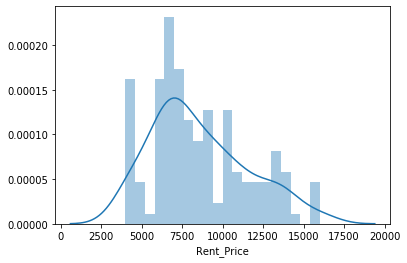

In [146]:
His1 = sns.distplot(NY_LL['Rent_Price'], bins = 20)

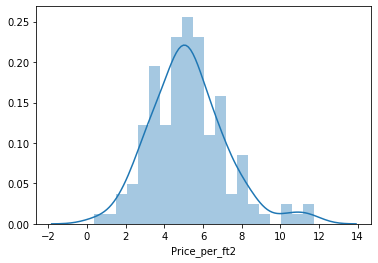

In [147]:
His2 = sns.distplot(NY_LL['Price_per_ft2'], bins = 20)

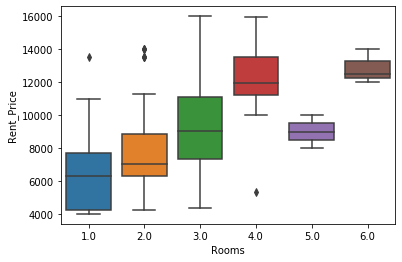

In [148]:
box1 = sns.boxplot(x = 'Rooms', y = 'Rent_Price', data = NY_LL)

In [141]:
latitude = 40.758896
longitude = -73.985130

map_rent = folium.Map(location = [latitude, longitude], zoom_start = 12)
for lat, lng, label in zip(NY_LL['Lat'], NY_LL['Long'],'$ ' + NY_LL['Rent_Price'].astype(str)+ ',  '+ NY_LL['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rent) 
    
for lat, lng, label in zip(dataframe_filtered['lat'], dataframe_filtered['lng'],  dataframe_filtered['address'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_rent) 
    
map_rent

In [155]:
latitude= 40.7308619
longitude= -73.9871558

kclusters=5
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=13)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, label in zip(NY_LL['Lat'], NY_LL['Long'],'$ ' + NY_LL['Rent_Price'].astype(str)+ NY_LL['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters2)  
map_clusters2

### clustering apartment in Manhattan

In [168]:
rent_c = NY_LL.drop(['Address', 'Area'], axis=1)
rent_c.head()

,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long,Clus_km
0,2.94,5.0,3400,10000,40.799771,-73.966213,0
1,3.57,3.0,2100,7500,40.788585,-73.955277,1
2,1.89,4.0,2800,5300,40.799771,-73.966213,1
3,3.03,2.0,1650,5000,40.730523,-74.001873,1
4,3.45,2.0,1450,5000,40.744118,-73.995299,1


In [170]:
from sklearn.preprocessing import StandardScaler
X = rent_c.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 2.61848695e+00,  7.45692825e-01,  4.81206720e-01,
         1.71705442e+00,  7.01535595e-01, -1.43750258e+00],
       [ 5.29500132e-01,  8.21584569e-02, -3.59545241e-01,
         1.28934621e+00,  1.26008574e+00,  6.53410263e-01],
       [ 1.57399354e+00,  4.39446194e-01, -1.09940697e+00,
         1.71705442e+00,  7.01535595e-01,  6.53410263e-01],
       [-5.14993279e-01, -1.47526517e-01, -1.20029720e+00,
        -9.30623172e-01, -1.11977406e+00,  6.53410263e-01],
       [-5.14993279e-01, -2.49608727e-01, -1.20029720e+00,
        -4.10819140e-01, -7.84010651e-01,  6.53410263e-01],
       [-5.14993279e-01, -3.00649833e-01, -1.26755736e+00,
        -9.64732514e-01, -1.25088647e+00,  6.53410263e-01],
       [-5.14993279e-01, -2.49608727e-01, -1.31800248e+00,
         1.00161128e+00,  1.55916238e+00,  6.53410263e-01],
       [ 5.29500132e-01,  2.50594104e-01, -1.36844759e+00,
         7.44110396e-01,  1.38476686e+00,  6.53410263e-01],
       [-5.14993279e-01, -2.75129280e-01, -1.368

In [187]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 2 2 0 2 2 0 3 3 2 3 3 3 3 3
 0 0 2 0 0 0 0 0 3 3 3 3 3 0 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 2 0 0 0 3 4 3 3
 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 2 2 2 2 2 0 0 2 2
 2 2 0 0 0 0 0 3 3 2 2 2 2 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 3 3 0]


In [188]:
rent_c["Clus_km"] = labels
rent_c.head(5)

,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long,Clus_km
0,2.94,5.0,3400,10000,40.799771,-73.966213,0
1,3.57,3.0,2100,7500,40.788585,-73.955277,3
2,1.89,4.0,2800,5300,40.799771,-73.966213,1
3,3.03,2.0,1650,5000,40.730523,-74.001873,1
4,3.45,2.0,1450,5000,40.744118,-73.995299,1


In [189]:
rent_c.groupby('Clus_km').mean()

,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
Clus_km,,,,,,
0,5.696154,2.641026,2094.102564,9847.461538,40.755920,-73.981903
1,3.367895,1.947368,1526.842105,4481.578947,40.759692,-73.972320
2,6.470000,3.280000,2371.000000,13604.680000,40.752725,-73.979102
3,5.090667,2.233333,1451.100000,6947.333333,40.754186,-73.981014
4,0.350000,3.000000,22200.000000,7795.000000,40.715887,-74.005873


In [190]:
NY_LL["Clus_km"] = labels
NY_LL

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long,Clus_km
0,West 105th Street,Upper West Side,2.94,5.0,3400,10000,40.799771,-73.966213,0
1,East 97th Street,Upper East Side,3.57,3.0,2100,7500,40.788585,-73.955277,3
2,West 105th Street,Upper West Side,1.89,4.0,2800,5300,40.799771,-73.966213,1
3,CARMINE ST.,West Village,3.03,2.0,1650,5000,40.730523,-74.001873,1
4,171 W 23RD ST.,Chelsea,3.45,2.0,1450,5000,40.744118,-73.995299,1
...,...,...,...,...,...,...,...,...,...
139,200 East 72nd Street,Rental in Lenox Hill,5.15,3.0,1700,8750,40.769465,-73.960339,0
140,50 Murray Street,No fee rental in Tribeca,7.11,2.0,1223,8700,40.714051,-74.009608,0
141,300 East 56th Street,No fee rental in Midtown East,3.87,3.0,2100,8118,40.758216,-73.965190,3
142,1930 Broadway,No fee rental in Central Park West,5.06,2.0,1600,8095,40.772474,-73.981901,3


In [191]:
latitude = 40.758896
longitude = -73.985130

clusterNum = 5
rent_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(clusterNum)
ys = [i+x+(i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(NY_LL['Lat'], NY_LL['Long'], NY_LL['Address'], NY_LL['Clus_km']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(rent_clusters)
 
    
       
rent_clusters

In [183]:
NY_LL.loc[NY_LL['Clus_km'] == 0, NY_LL.columns[[1] + list(range(5, NY_LL.shape[1]))]]

,Area,Rent_Price,Lat,Long,Clus_km
0,Upper West Side,10000,40.799771,-73.966213,0
22,Rental in Yorkville,15984,40.782727,-73.950401,0
23,Rental in Greenwich Village,15950,40.728046,-74.001476,0
24,Rental in Financial District,12000,40.708672,-74.013428,0
25,Rental in Yorkville,11016,40.775967,-73.955610,0
26,Rental in Riverside Dr./West End Ave.,15950,40.784278,-73.981434,0
27,Rental in Yorkville,13511,40.778834,-73.953789,0
31,Rental in Tribeca,11950,40.714303,-74.007680,0
37,Rental in Central Park West,10000,40.788745,-73.967049,0
39,No fee rental in Yorkville,11950,40.775941,-73.952773,0
